In [ ]:
# import zipfile

# with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Defect Detection class

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np
import cv2

class DefectDataset(Dataset):
    def __init__(self, images, annotations, filenames, transform=None):
        self.images = images
        self.annotations = annotations
        self.filenames = filenames
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        annotation = self.annotations[idx]
        filename = self.filenames[idx]

        if self.transform:
            image = self.transform(image)

        # Convert bounding box annotation to a mask
        mask = np.zeros((image.shape[1], image.shape[2]), dtype=np.float32)
        xmin, ymin, xmax, ymax = annotation
        mask[ymin:ymax, xmin:xmax] = 1

        # Convert mask to tensor and add channel dimension
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask, filename

Build Unet with ResNet34 encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms

class UNetResNet34(nn.Module):
    def __init__(self, n_classes):
        super(UNetResNet34, self).__init__()
        self.encoder = models.resnet34(pretrained=True)
        self.encoder_layers = list(self.encoder.children())

        self.conv1 = nn.Sequential(*self.encoder_layers[:3])
        self.conv2 = nn.Sequential(*self.encoder_layers[3:5])
        self.conv3 = self.encoder_layers[5]
        self.conv4 = self.encoder_layers[6]
        self.conv5 = self.encoder_layers[7]

        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        upconv4 = self.upconv4(conv5)
        upconv4 = crop_tensor(upconv4, conv4)
        upconv3 = self.upconv3(upconv4 + conv4)
        upconv3 = crop_tensor(upconv3, conv3)
        upconv2 = self.upconv2(upconv3 + conv3)
        upconv2 = crop_tensor(upconv2, conv2)
        upconv1 = self.upconv1(upconv2 + conv2)
        upconv1 = crop_tensor(upconv1, conv1)

        output = self.final_conv(upconv1 + conv1)
        return output

Load and preprocess dataset

In [ ]:
# Ensure transformations applied correctly
from torchvision import transforms
from torch.utils.data import DataLoader

batch_size = 10  # Determines how many validation printed at the end

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# train_dataset = DefectDataset(train_images, train_annotations, _, transform=transform)
# val_dataset = DefectDataset(val_images, val_annotations, _, transform=transform)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_images_and_annotations(image_folder, annotation_folder):
    images = []
    annotations = []
    classes = []
    filenames = []

    for filename in os.listdir(image_folder):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_folder, filename)
            annotation_path = os.path.join(annotation_folder, filename.replace(".jpg", ".xml"))

            # Load image
            image = cv2.imread(image_path)
            images.append(image)

            # Load annotation
            tree = ET.parse(annotation_path)
            root = tree.getroot()
            for member in root.findall('object'):
                bndbox = member.find('bndbox')
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
            annotations.append([xmin, ymin, xmax, ymax])
            classes.append(member.find('name').text)
            filenames.append(filename)

    return images, annotations, classes, filenames

train_images, train_annotations, train_classes, train_filenames = load_images_and_annotations("IMAGES", "ANNOTATIONS")
val_images, val_annotations, val_classes, val_filenames = load_images_and_annotations("Validation_Images", "Validation_Annotations")

# Split the dataset
train_images, val_images, train_annotations, val_annotations, train_classes, val_classes, train_filenames, val_filenames = train_test_split(
    train_images, train_annotations, train_classes, train_filenames, test_size=0.2, random_state=42)

train_dataset = DefectDataset(train_images, train_annotations, train_filenames, transform=transform)
val_dataset = DefectDataset(val_images, val_annotations, val_filenames, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Cropping function

In [ ]:
import torch.nn.functional as F

def crop_tensor(tensor, target_tensor):
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_height = tensor_size[0] - target_size[0]
    delta_width = tensor_size[1] - target_size[1]
    crop_top = delta_height // 2
    crop_bottom = delta_height - crop_top
    crop_left = delta_width // 2
    crop_right = delta_width - crop_left
    return tensor[:, :, crop_top:tensor_size[0]-crop_bottom, crop_left:tensor_size[1]-crop_right]

Train

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Training Epoch 1/100:   0%|          | 0/142 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.

Epoch 1/100, Train Loss: 0.4634, Val Loss: 0.3839, Train Dice Score: 25.3045, Val Dice Score: 9.2552, Train IoU Score: 15.1448, Val IoU Score: 5.9400


Validation Epoch 2/100: 100%|██████████| 36/36 [00:03<00:00, 11.90it/s]


Epoch 2/100, Train Loss: 0.3690, Val Loss: 0.4059, Train Dice Score: 45.8818, Val Dice Score: 12.8895, Train IoU Score: 30.2919, Val IoU Score: 8.9158


Validation Epoch 3/100: 100%|██████████| 36/36 [00:03<00:00, 11.96it/s]


Epoch 3/100, Train Loss: 0.3540, Val Loss: 0.3793, Train Dice Score: 62.7040, Val Dice Score: 15.6816, Train IoU Score: 42.9473, Val IoU Score: 11.1205


Validation Epoch 4/100: 100%|██████████| 36/36 [00:04<00:00,  8.74it/s]


Epoch 4/100, Train Loss: 0.3085, Val Loss: 0.3601, Train Dice Score: 82.1359, Val Dice Score: 17.1953, Train IoU Score: 59.7312, Val IoU Score: 12.1383


Validation Epoch 5/100: 100%|██████████| 36/36 [00:04<00:00,  8.62it/s]


Epoch 5/100, Train Loss: 0.2655, Val Loss: 0.3863, Train Dice Score: 94.4717, Val Dice Score: 17.6999, Train IoU Score: 72.6599, Val IoU Score: 12.4417


Validation Epoch 6/100: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s]


Epoch 6/100, Train Loss: 0.2361, Val Loss: 0.4108, Train Dice Score: 101.9921, Val Dice Score: 17.3642, Train IoU Score: 81.2469, Val IoU Score: 12.4212


Validation Epoch 7/100: 100%|██████████| 36/36 [00:03<00:00, 11.86it/s]


Epoch 7/100, Train Loss: 0.1874, Val Loss: 0.4335, Train Dice Score: 112.2067, Val Dice Score: 18.1347, Train IoU Score: 93.7541, Val IoU Score: 12.6954


Validation Epoch 8/100: 100%|██████████| 36/36 [00:03<00:00, 10.61it/s]


Epoch 8/100, Train Loss: 0.1591, Val Loss: 0.4398, Train Dice Score: 116.6750, Val Dice Score: 19.9053, Train IoU Score: 99.9430, Val IoU Score: 14.3489


Validation Epoch 9/100: 100%|██████████| 36/36 [00:03<00:00, 10.09it/s]


Epoch 9/100, Train Loss: 0.1333, Val Loss: 0.5365, Train Dice Score: 121.1437, Val Dice Score: 17.8042, Train IoU Score: 106.1698, Val IoU Score: 12.7224


Validation Epoch 10/100: 100%|██████████| 36/36 [00:02<00:00, 12.02it/s]


Epoch 10/100, Train Loss: 0.1116, Val Loss: 0.5292, Train Dice Score: 124.8662, Val Dice Score: 19.2501, Train IoU Score: 111.7842, Val IoU Score: 13.7740
Model saved to defect_detect_trained_model_epoch_10.pth


Validation Epoch 11/100: 100%|██████████| 36/36 [00:03<00:00, 11.80it/s]


Epoch 11/100, Train Loss: 0.0995, Val Loss: 0.5484, Train Dice Score: 126.2817, Val Dice Score: 19.0521, Train IoU Score: 114.0285, Val IoU Score: 13.6454


Validation Epoch 12/100: 100%|██████████| 36/36 [00:04<00:00,  8.98it/s]


Epoch 12/100, Train Loss: 0.0889, Val Loss: 0.6100, Train Dice Score: 128.4488, Val Dice Score: 18.1732, Train IoU Score: 117.5254, Val IoU Score: 12.9891


Validation Epoch 13/100: 100%|██████████| 36/36 [00:03<00:00, 11.95it/s]


Epoch 13/100, Train Loss: 0.0727, Val Loss: 0.6210, Train Dice Score: 130.4677, Val Dice Score: 18.4714, Train IoU Score: 120.8306, Val IoU Score: 13.2091


Validation Epoch 14/100: 100%|██████████| 36/36 [00:02<00:00, 12.09it/s]


Epoch 14/100, Train Loss: 0.0657, Val Loss: 0.6379, Train Dice Score: 131.5328, Val Dice Score: 18.5584, Train IoU Score: 122.6680, Val IoU Score: 13.2884


Validation Epoch 15/100: 100%|██████████| 36/36 [00:03<00:00, 11.60it/s]


Epoch 15/100, Train Loss: 0.0576, Val Loss: 0.8745, Train Dice Score: 132.8407, Val Dice Score: 16.9545, Train IoU Score: 124.9177, Val IoU Score: 12.1396


Validation Epoch 16/100: 100%|██████████| 36/36 [00:03<00:00,  9.45it/s]


Epoch 16/100, Train Loss: 0.0519, Val Loss: 0.7283, Train Dice Score: 133.7909, Val Dice Score: 18.3005, Train IoU Score: 126.5795, Val IoU Score: 12.8773


Validation Epoch 17/100: 100%|██████████| 36/36 [00:03<00:00, 11.94it/s]


Epoch 17/100, Train Loss: 0.0571, Val Loss: 0.7286, Train Dice Score: 132.9218, Val Dice Score: 18.5601, Train IoU Score: 125.1292, Val IoU Score: 13.2793


Validation Epoch 18/100: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s]


Epoch 18/100, Train Loss: 0.0475, Val Loss: 0.7198, Train Dice Score: 134.4434, Val Dice Score: 18.4694, Train IoU Score: 127.7379, Val IoU Score: 13.1354


Validation Epoch 19/100: 100%|██████████| 36/36 [00:04<00:00,  8.76it/s]


Epoch 19/100, Train Loss: 0.0454, Val Loss: 0.7353, Train Dice Score: 134.7909, Val Dice Score: 18.8664, Train IoU Score: 128.3471, Val IoU Score: 13.5548


Validation Epoch 20/100: 100%|██████████| 36/36 [00:02<00:00, 12.14it/s]


Epoch 20/100, Train Loss: 0.0441, Val Loss: 0.8635, Train Dice Score: 134.9863, Val Dice Score: 18.2043, Train IoU Score: 128.7103, Val IoU Score: 13.0390
Model saved to defect_detect_trained_model_epoch_20.pth


Validation Epoch 21/100: 100%|██████████| 36/36 [00:02<00:00, 12.10it/s]


Epoch 21/100, Train Loss: 0.0471, Val Loss: 0.6603, Train Dice Score: 134.6254, Val Dice Score: 19.5010, Train IoU Score: 128.0554, Val IoU Score: 13.9988


Validation Epoch 22/100: 100%|██████████| 36/36 [00:03<00:00, 11.72it/s]


Epoch 22/100, Train Loss: 0.0391, Val Loss: 0.7651, Train Dice Score: 135.7749, Val Dice Score: 19.1524, Train IoU Score: 130.1323, Val IoU Score: 13.6814


Validation Epoch 23/100: 100%|██████████| 36/36 [00:03<00:00,  9.52it/s]


Epoch 23/100, Train Loss: 0.0349, Val Loss: 0.8072, Train Dice Score: 136.3032, Val Dice Score: 18.9816, Train IoU Score: 131.1096, Val IoU Score: 13.6106


Validation Epoch 24/100: 100%|██████████| 36/36 [00:02<00:00, 12.11it/s]


Epoch 24/100, Train Loss: 0.0325, Val Loss: 0.9051, Train Dice Score: 136.7928, Val Dice Score: 17.4376, Train IoU Score: 131.9923, Val IoU Score: 12.3902


Validation Epoch 25/100: 100%|██████████| 36/36 [00:03<00:00, 11.82it/s]


Epoch 25/100, Train Loss: 0.0312, Val Loss: 0.8741, Train Dice Score: 137.0233, Val Dice Score: 18.5721, Train IoU Score: 132.4168, Val IoU Score: 13.2604


Validation Epoch 26/100: 100%|██████████| 36/36 [00:03<00:00,  9.36it/s]


Epoch 26/100, Train Loss: 0.0293, Val Loss: 0.8718, Train Dice Score: 137.3318, Val Dice Score: 18.7719, Train IoU Score: 132.9887, Val IoU Score: 13.4098


Validation Epoch 27/100: 100%|██████████| 36/36 [00:03<00:00, 11.82it/s]


Epoch 27/100, Train Loss: 0.0276, Val Loss: 0.8914, Train Dice Score: 137.4928, Val Dice Score: 18.6464, Train IoU Score: 133.2986, Val IoU Score: 13.3238


Validation Epoch 28/100: 100%|██████████| 36/36 [00:02<00:00, 12.08it/s]


Epoch 28/100, Train Loss: 0.0268, Val Loss: 0.9227, Train Dice Score: 137.6262, Val Dice Score: 18.8243, Train IoU Score: 133.5471, Val IoU Score: 13.4375


Validation Epoch 29/100: 100%|██████████| 36/36 [00:03<00:00, 10.72it/s]


Epoch 29/100, Train Loss: 0.0249, Val Loss: 1.0015, Train Dice Score: 137.8976, Val Dice Score: 18.4627, Train IoU Score: 134.0538, Val IoU Score: 13.2056


Validation Epoch 30/100: 100%|██████████| 36/36 [00:03<00:00, 10.47it/s]


Epoch 30/100, Train Loss: 0.0242, Val Loss: 0.9650, Train Dice Score: 138.0374, Val Dice Score: 18.5248, Train IoU Score: 134.3142, Val IoU Score: 13.2180
Model saved to defect_detect_trained_model_epoch_30.pth


Validation Epoch 31/100: 100%|██████████| 36/36 [00:03<00:00, 11.91it/s]


Epoch 31/100, Train Loss: 0.0242, Val Loss: 0.9845, Train Dice Score: 138.0181, Val Dice Score: 18.4750, Train IoU Score: 134.2831, Val IoU Score: 13.1687


Validation Epoch 32/100: 100%|██████████| 36/36 [00:03<00:00, 11.94it/s]


Epoch 32/100, Train Loss: 0.0239, Val Loss: 0.9500, Train Dice Score: 138.1175, Val Dice Score: 18.5888, Train IoU Score: 134.4671, Val IoU Score: 13.3612


Validation Epoch 33/100: 100%|██████████| 36/36 [00:04<00:00,  8.99it/s]


Epoch 33/100, Train Loss: 0.0222, Val Loss: 1.0121, Train Dice Score: 138.4181, Val Dice Score: 18.8095, Train IoU Score: 135.0332, Val IoU Score: 13.4880


Validation Epoch 34/100: 100%|██████████| 36/36 [00:02<00:00, 12.11it/s]


Epoch 34/100, Train Loss: 0.0217, Val Loss: 0.9295, Train Dice Score: 138.5126, Val Dice Score: 19.3146, Train IoU Score: 135.2121, Val IoU Score: 13.8060


Validation Epoch 35/100: 100%|██████████| 36/36 [00:02<00:00, 12.24it/s]


Epoch 35/100, Train Loss: 0.0215, Val Loss: 1.0441, Train Dice Score: 138.4017, Val Dice Score: 18.3016, Train IoU Score: 135.0008, Val IoU Score: 13.0852


Validation Epoch 36/100: 100%|██████████| 36/36 [00:03<00:00, 10.00it/s]


Epoch 36/100, Train Loss: 0.0727, Val Loss: 0.4910, Train Dice Score: 131.3061, Val Dice Score: 15.6871, Train IoU Score: 123.6359, Val IoU Score: 10.4244


Validation Epoch 37/100: 100%|██████████| 36/36 [00:03<00:00, 10.66it/s]


Epoch 37/100, Train Loss: 0.1364, Val Loss: 0.6446, Train Dice Score: 120.9257, Val Dice Score: 16.4304, Train IoU Score: 106.1402, Val IoU Score: 11.2756


Validation Epoch 38/100: 100%|██████████| 36/36 [00:02<00:00, 12.13it/s]


Epoch 38/100, Train Loss: 0.0818, Val Loss: 0.6721, Train Dice Score: 129.4892, Val Dice Score: 18.2388, Train IoU Score: 119.6444, Val IoU Score: 13.0100


Validation Epoch 39/100: 100%|██████████| 36/36 [00:02<00:00, 12.17it/s]


Epoch 39/100, Train Loss: 0.0413, Val Loss: 0.7643, Train Dice Score: 135.4776, Val Dice Score: 18.4753, Train IoU Score: 129.6762, Val IoU Score: 13.2757


Validation Epoch 40/100: 100%|██████████| 36/36 [00:04<00:00,  8.78it/s]


Epoch 40/100, Train Loss: 0.0276, Val Loss: 0.7871, Train Dice Score: 137.5269, Val Dice Score: 19.0900, Train IoU Score: 133.3588, Val IoU Score: 13.7625
Model saved to defect_detect_trained_model_epoch_40.pth


Validation Epoch 41/100: 100%|██████████| 36/36 [00:02<00:00, 12.24it/s]


Epoch 41/100, Train Loss: 0.0228, Val Loss: 0.8260, Train Dice Score: 138.3908, Val Dice Score: 19.1079, Train IoU Score: 134.9768, Val IoU Score: 13.7776


Validation Epoch 42/100: 100%|██████████| 36/36 [00:02<00:00, 12.24it/s]


Epoch 42/100, Train Loss: 0.0204, Val Loss: 0.9272, Train Dice Score: 138.6248, Val Dice Score: 18.9034, Train IoU Score: 135.4251, Val IoU Score: 13.5879


Validation Epoch 43/100: 100%|██████████| 36/36 [00:03<00:00, 10.00it/s]


Epoch 43/100, Train Loss: 0.0191, Val Loss: 0.9563, Train Dice Score: 138.8983, Val Dice Score: 18.7337, Train IoU Score: 135.9420, Val IoU Score: 13.4968


Validation Epoch 44/100: 100%|██████████| 36/36 [00:03<00:00, 11.13it/s]


Epoch 44/100, Train Loss: 0.0182, Val Loss: 1.0107, Train Dice Score: 139.0436, Val Dice Score: 18.5200, Train IoU Score: 136.2201, Val IoU Score: 13.3239


Validation Epoch 45/100: 100%|██████████| 36/36 [00:02<00:00, 12.16it/s]


Epoch 45/100, Train Loss: 0.0181, Val Loss: 1.0103, Train Dice Score: 139.0441, Val Dice Score: 18.7320, Train IoU Score: 136.2206, Val IoU Score: 13.4987


Validation Epoch 46/100: 100%|██████████| 36/36 [00:03<00:00, 11.83it/s]


Epoch 46/100, Train Loss: 0.0519, Val Loss: 0.6361, Train Dice Score: 134.9063, Val Dice Score: 19.2291, Train IoU Score: 128.9453, Val IoU Score: 13.6158


Validation Epoch 47/100: 100%|██████████| 36/36 [00:03<00:00,  9.40it/s]


Epoch 47/100, Train Loss: 0.0465, Val Loss: 0.7389, Train Dice Score: 135.0415, Val Dice Score: 18.7567, Train IoU Score: 128.8670, Val IoU Score: 13.4684


Validation Epoch 48/100: 100%|██████████| 36/36 [00:02<00:00, 12.05it/s]


Epoch 48/100, Train Loss: 0.0262, Val Loss: 0.7892, Train Dice Score: 137.9781, Val Dice Score: 19.0857, Train IoU Score: 134.2056, Val IoU Score: 13.7150


Validation Epoch 49/100: 100%|██████████| 36/36 [00:02<00:00, 12.10it/s]


Epoch 49/100, Train Loss: 0.0205, Val Loss: 0.8865, Train Dice Score: 138.6509, Val Dice Score: 18.5473, Train IoU Score: 135.4728, Val IoU Score: 13.3101


Validation Epoch 50/100: 100%|██████████| 36/36 [00:04<00:00,  8.55it/s]


Epoch 50/100, Train Loss: 0.0182, Val Loss: 0.9332, Train Dice Score: 139.0296, Val Dice Score: 18.6640, Train IoU Score: 136.1939, Val IoU Score: 13.4165
Model saved to defect_detect_trained_model_epoch_50.pth


Validation Epoch 51/100: 100%|██████████| 36/36 [00:02<00:00, 12.01it/s]


Epoch 51/100, Train Loss: 0.0172, Val Loss: 0.9580, Train Dice Score: 139.1509, Val Dice Score: 18.2646, Train IoU Score: 136.4269, Val IoU Score: 13.1125


Validation Epoch 52/100: 100%|██████████| 36/36 [00:03<00:00, 11.93it/s]


Epoch 52/100, Train Loss: 0.0164, Val Loss: 0.9866, Train Dice Score: 139.2809, Val Dice Score: 18.6103, Train IoU Score: 136.6773, Val IoU Score: 13.3672


Validation Epoch 53/100: 100%|██████████| 36/36 [00:03<00:00, 11.21it/s]


Epoch 53/100, Train Loss: 0.0158, Val Loss: 0.9965, Train Dice Score: 139.3995, Val Dice Score: 18.2691, Train IoU Score: 136.9002, Val IoU Score: 13.1415


Validation Epoch 54/100: 100%|██████████| 36/36 [00:03<00:00,  9.75it/s]


Epoch 54/100, Train Loss: 0.0156, Val Loss: 1.0086, Train Dice Score: 139.4445, Val Dice Score: 18.5310, Train IoU Score: 136.9897, Val IoU Score: 13.2935


Validation Epoch 55/100: 100%|██████████| 36/36 [00:02<00:00, 12.11it/s]


Epoch 55/100, Train Loss: 0.0159, Val Loss: 1.0553, Train Dice Score: 139.3826, Val Dice Score: 18.3120, Train IoU Score: 136.8720, Val IoU Score: 13.1316


Validation Epoch 56/100: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s]


Epoch 56/100, Train Loss: 0.0157, Val Loss: 0.9939, Train Dice Score: 139.4497, Val Dice Score: 18.6817, Train IoU Score: 136.9987, Val IoU Score: 13.3947


Validation Epoch 57/100: 100%|██████████| 36/36 [00:04<00:00,  8.64it/s]


Epoch 57/100, Train Loss: 0.0153, Val Loss: 1.0073, Train Dice Score: 139.4738, Val Dice Score: 18.7089, Train IoU Score: 137.0443, Val IoU Score: 13.4300


Validation Epoch 58/100: 100%|██████████| 36/36 [00:02<00:00, 12.18it/s]


Epoch 58/100, Train Loss: 0.0151, Val Loss: 1.0483, Train Dice Score: 139.4731, Val Dice Score: 18.5332, Train IoU Score: 137.0443, Val IoU Score: 13.3145


Validation Epoch 59/100: 100%|██████████| 36/36 [00:02<00:00, 12.14it/s]


Epoch 59/100, Train Loss: 0.0153, Val Loss: 1.0069, Train Dice Score: 139.5300, Val Dice Score: 18.1255, Train IoU Score: 137.1524, Val IoU Score: 12.9553


Validation Epoch 60/100: 100%|██████████| 36/36 [00:03<00:00,  9.77it/s]


Epoch 60/100, Train Loss: 0.0149, Val Loss: 0.9810, Train Dice Score: 139.5404, Val Dice Score: 18.7774, Train IoU Score: 137.1739, Val IoU Score: 13.5168
Model saved to defect_detect_trained_model_epoch_60.pth


Validation Epoch 61/100: 100%|██████████| 36/36 [00:03<00:00, 10.85it/s]


Epoch 61/100, Train Loss: 0.0143, Val Loss: 1.0142, Train Dice Score: 139.5928, Val Dice Score: 18.5285, Train IoU Score: 137.2736, Val IoU Score: 13.3126


Validation Epoch 62/100: 100%|██████████| 36/36 [00:02<00:00, 12.00it/s]


Epoch 62/100, Train Loss: 0.0144, Val Loss: 1.0344, Train Dice Score: 139.5696, Val Dice Score: 18.0817, Train IoU Score: 137.2311, Val IoU Score: 12.9513


Validation Epoch 63/100: 100%|██████████| 36/36 [00:02<00:00, 12.15it/s]


Epoch 63/100, Train Loss: 0.0146, Val Loss: 1.0056, Train Dice Score: 139.5842, Val Dice Score: 18.3531, Train IoU Score: 137.2583, Val IoU Score: 13.1533


Validation Epoch 64/100: 100%|██████████| 36/36 [00:03<00:00,  9.26it/s]


Epoch 64/100, Train Loss: 0.0147, Val Loss: 1.0269, Train Dice Score: 139.6293, Val Dice Score: 18.2556, Train IoU Score: 137.3450, Val IoU Score: 13.0106


Validation Epoch 65/100: 100%|██████████| 36/36 [00:02<00:00, 12.06it/s]


Epoch 65/100, Train Loss: 0.0144, Val Loss: 1.0015, Train Dice Score: 139.6152, Val Dice Score: 18.6129, Train IoU Score: 137.3175, Val IoU Score: 13.3133


Validation Epoch 66/100: 100%|██████████| 36/36 [00:02<00:00, 12.21it/s]


Epoch 66/100, Train Loss: 0.0141, Val Loss: 0.9879, Train Dice Score: 139.6920, Val Dice Score: 18.9360, Train IoU Score: 137.4669, Val IoU Score: 13.5933


Validation Epoch 67/100: 100%|██████████| 36/36 [00:03<00:00,  9.17it/s]


Epoch 67/100, Train Loss: 0.0139, Val Loss: 1.0257, Train Dice Score: 139.6760, Val Dice Score: 18.7284, Train IoU Score: 137.4359, Val IoU Score: 13.4335


Validation Epoch 68/100: 100%|██████████| 36/36 [00:03<00:00, 11.37it/s]


Epoch 68/100, Train Loss: 0.0142, Val Loss: 0.9654, Train Dice Score: 139.6448, Val Dice Score: 18.9468, Train IoU Score: 137.3757, Val IoU Score: 13.6023


Validation Epoch 69/100: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s]


Epoch 69/100, Train Loss: 0.0142, Val Loss: 0.9606, Train Dice Score: 139.6436, Val Dice Score: 18.5308, Train IoU Score: 137.3728, Val IoU Score: 13.3211


Validation Epoch 70/100: 100%|██████████| 36/36 [00:03<00:00, 11.86it/s]


Epoch 70/100, Train Loss: 0.0137, Val Loss: 1.0662, Train Dice Score: 139.7450, Val Dice Score: 17.9544, Train IoU Score: 137.5686, Val IoU Score: 12.8678
Model saved to defect_detect_trained_model_epoch_70.pth


Validation Epoch 71/100: 100%|██████████| 36/36 [00:03<00:00,  9.27it/s]


Epoch 71/100, Train Loss: 0.0134, Val Loss: 1.0539, Train Dice Score: 139.8338, Val Dice Score: 18.2768, Train IoU Score: 137.7393, Val IoU Score: 13.0815


Validation Epoch 72/100: 100%|██████████| 36/36 [00:03<00:00, 11.99it/s]


Epoch 72/100, Train Loss: 0.0166, Val Loss: 0.9546, Train Dice Score: 139.5550, Val Dice Score: 16.1421, Train IoU Score: 137.2121, Val IoU Score: 11.3090


Validation Epoch 73/100: 100%|██████████| 36/36 [00:02<00:00, 12.07it/s]


Epoch 73/100, Train Loss: 0.1186, Val Loss: 0.5537, Train Dice Score: 124.4525, Val Dice Score: 17.9845, Train IoU Score: 112.4944, Val IoU Score: 12.7111


Validation Epoch 74/100: 100%|██████████| 36/36 [00:03<00:00,  9.11it/s]


Epoch 74/100, Train Loss: 0.0845, Val Loss: 0.6992, Train Dice Score: 129.9335, Val Dice Score: 17.6726, Train IoU Score: 120.3055, Val IoU Score: 12.6061


Validation Epoch 75/100: 100%|██████████| 36/36 [00:03<00:00, 10.56it/s]


Epoch 75/100, Train Loss: 0.0329, Val Loss: 0.7760, Train Dice Score: 136.9560, Val Dice Score: 18.8454, Train IoU Score: 132.3388, Val IoU Score: 13.5353


Validation Epoch 76/100: 100%|██████████| 36/36 [00:03<00:00, 11.99it/s]


Epoch 76/100, Train Loss: 0.0214, Val Loss: 0.9020, Train Dice Score: 138.5618, Val Dice Score: 17.6914, Train IoU Score: 135.3064, Val IoU Score: 12.6566


Validation Epoch 77/100: 100%|██████████| 36/36 [00:02<00:00, 12.04it/s]


Epoch 77/100, Train Loss: 0.0160, Val Loss: 0.9913, Train Dice Score: 139.4331, Val Dice Score: 18.1977, Train IoU Score: 136.9668, Val IoU Score: 13.0049


Validation Epoch 78/100: 100%|██████████| 36/36 [00:04<00:00,  8.91it/s]


Epoch 78/100, Train Loss: 0.0143, Val Loss: 1.0246, Train Dice Score: 139.6429, Val Dice Score: 17.9593, Train IoU Score: 137.3722, Val IoU Score: 12.8776


Validation Epoch 79/100: 100%|██████████| 36/36 [00:03<00:00, 11.95it/s]


Epoch 79/100, Train Loss: 0.0134, Val Loss: 1.1394, Train Dice Score: 139.7511, Val Dice Score: 17.5134, Train IoU Score: 137.5815, Val IoU Score: 12.5571


Validation Epoch 80/100: 100%|██████████| 36/36 [00:02<00:00, 12.09it/s]


Epoch 80/100, Train Loss: 0.0130, Val Loss: 1.1590, Train Dice Score: 139.8025, Val Dice Score: 17.4660, Train IoU Score: 137.6798, Val IoU Score: 12.4772
Model saved to defect_detect_trained_model_epoch_80.pth


Validation Epoch 81/100: 100%|██████████| 36/36 [00:03<00:00, 11.59it/s]


Epoch 81/100, Train Loss: 0.0129, Val Loss: 1.1171, Train Dice Score: 139.8464, Val Dice Score: 17.6025, Train IoU Score: 137.7639, Val IoU Score: 12.6069


Validation Epoch 82/100: 100%|██████████| 36/36 [00:03<00:00,  9.53it/s]


Epoch 82/100, Train Loss: 0.0124, Val Loss: 1.1064, Train Dice Score: 139.8500, Val Dice Score: 18.1136, Train IoU Score: 137.7728, Val IoU Score: 13.0241


Validation Epoch 83/100: 100%|██████████| 36/36 [00:02<00:00, 12.06it/s]


Epoch 83/100, Train Loss: 0.0122, Val Loss: 1.1112, Train Dice Score: 139.9553, Val Dice Score: 17.8842, Train IoU Score: 137.9753, Val IoU Score: 12.8513


Validation Epoch 84/100: 100%|██████████| 36/36 [00:03<00:00, 11.92it/s]


Epoch 84/100, Train Loss: 0.0120, Val Loss: 1.1579, Train Dice Score: 139.9710, Val Dice Score: 17.7292, Train IoU Score: 138.0052, Val IoU Score: 12.6822


Validation Epoch 85/100: 100%|██████████| 36/36 [00:03<00:00,  9.32it/s]


Epoch 85/100, Train Loss: 0.0119, Val Loss: 1.1364, Train Dice Score: 139.9799, Val Dice Score: 17.5845, Train IoU Score: 138.0248, Val IoU Score: 12.6307


Validation Epoch 86/100: 100%|██████████| 36/36 [00:03<00:00, 11.00it/s]


Epoch 86/100, Train Loss: 0.0118, Val Loss: 1.0925, Train Dice Score: 140.0176, Val Dice Score: 17.6745, Train IoU Score: 138.0957, Val IoU Score: 12.6535


Validation Epoch 87/100: 100%|██████████| 36/36 [00:02<00:00, 12.02it/s]


Epoch 87/100, Train Loss: 0.0117, Val Loss: 1.2061, Train Dice Score: 140.0047, Val Dice Score: 17.2946, Train IoU Score: 138.0702, Val IoU Score: 12.3699


Validation Epoch 88/100: 100%|██████████| 36/36 [00:03<00:00, 11.88it/s]


Epoch 88/100, Train Loss: 0.0116, Val Loss: 1.0990, Train Dice Score: 139.9902, Val Dice Score: 18.0126, Train IoU Score: 138.0441, Val IoU Score: 12.9766


Validation Epoch 89/100: 100%|██████████| 36/36 [00:04<00:00,  8.76it/s]


Epoch 89/100, Train Loss: 0.0116, Val Loss: 1.0973, Train Dice Score: 139.9960, Val Dice Score: 18.0596, Train IoU Score: 138.0563, Val IoU Score: 12.9907


Validation Epoch 90/100: 100%|██████████| 36/36 [00:03<00:00, 11.99it/s]


Epoch 90/100, Train Loss: 0.0116, Val Loss: 1.0751, Train Dice Score: 140.0323, Val Dice Score: 18.3969, Train IoU Score: 138.1259, Val IoU Score: 13.2400
Model saved to defect_detect_trained_model_epoch_90.pth


Validation Epoch 91/100: 100%|██████████| 36/36 [00:03<00:00, 12.00it/s]


Epoch 91/100, Train Loss: 0.0115, Val Loss: 1.0861, Train Dice Score: 140.0204, Val Dice Score: 18.1407, Train IoU Score: 138.1016, Val IoU Score: 13.0746


Validation Epoch 92/100: 100%|██████████| 36/36 [00:03<00:00, 10.04it/s]


Epoch 92/100, Train Loss: 0.0114, Val Loss: 1.0817, Train Dice Score: 140.0106, Val Dice Score: 17.9904, Train IoU Score: 138.0836, Val IoU Score: 12.9120


Validation Epoch 93/100: 100%|██████████| 36/36 [00:03<00:00, 10.84it/s]


Epoch 93/100, Train Loss: 0.0115, Val Loss: 1.0999, Train Dice Score: 140.0007, Val Dice Score: 17.8378, Train IoU Score: 138.0633, Val IoU Score: 12.8403


Validation Epoch 94/100: 100%|██████████| 36/36 [00:02<00:00, 12.05it/s]


Epoch 94/100, Train Loss: 0.0114, Val Loss: 1.1217, Train Dice Score: 140.0894, Val Dice Score: 18.1007, Train IoU Score: 138.2355, Val IoU Score: 13.0558


Validation Epoch 95/100: 100%|██████████| 36/36 [00:02<00:00, 12.05it/s]


Epoch 95/100, Train Loss: 0.0111, Val Loss: 1.1482, Train Dice Score: 140.1002, Val Dice Score: 18.0512, Train IoU Score: 138.2572, Val IoU Score: 13.0088


Validation Epoch 96/100: 100%|██████████| 36/36 [00:04<00:00,  8.76it/s]


Epoch 96/100, Train Loss: 0.0109, Val Loss: 1.0748, Train Dice Score: 140.1438, Val Dice Score: 18.3409, Train IoU Score: 138.3415, Val IoU Score: 13.2228


Validation Epoch 97/100: 100%|██████████| 36/36 [00:02<00:00, 12.13it/s]


Epoch 97/100, Train Loss: 0.0110, Val Loss: 1.1675, Train Dice Score: 140.1450, Val Dice Score: 17.9655, Train IoU Score: 138.3429, Val IoU Score: 12.9233


Validation Epoch 98/100: 100%|██████████| 36/36 [00:03<00:00, 11.95it/s]


Epoch 98/100, Train Loss: 0.0111, Val Loss: 1.1235, Train Dice Score: 140.0634, Val Dice Score: 17.8390, Train IoU Score: 138.1850, Val IoU Score: 12.8454


Validation Epoch 99/100: 100%|██████████| 36/36 [00:03<00:00, 10.19it/s]


Epoch 99/100, Train Loss: 0.0111, Val Loss: 1.0696, Train Dice Score: 140.1335, Val Dice Score: 18.1349, Train IoU Score: 138.3216, Val IoU Score: 12.9969


Validation Epoch 100/100: 100%|██████████| 36/36 [00:03<00:00, 10.62it/s]


Epoch 100/100, Train Loss: 0.0111, Val Loss: 1.0968, Train Dice Score: 140.1091, Val Dice Score: 18.0312, Train IoU Score: 138.2738, Val IoU Score: 12.9477
Model saved to defect_detect_trained_model_epoch_100.pth
Model saved to defect_detect_trained_model_final.pth


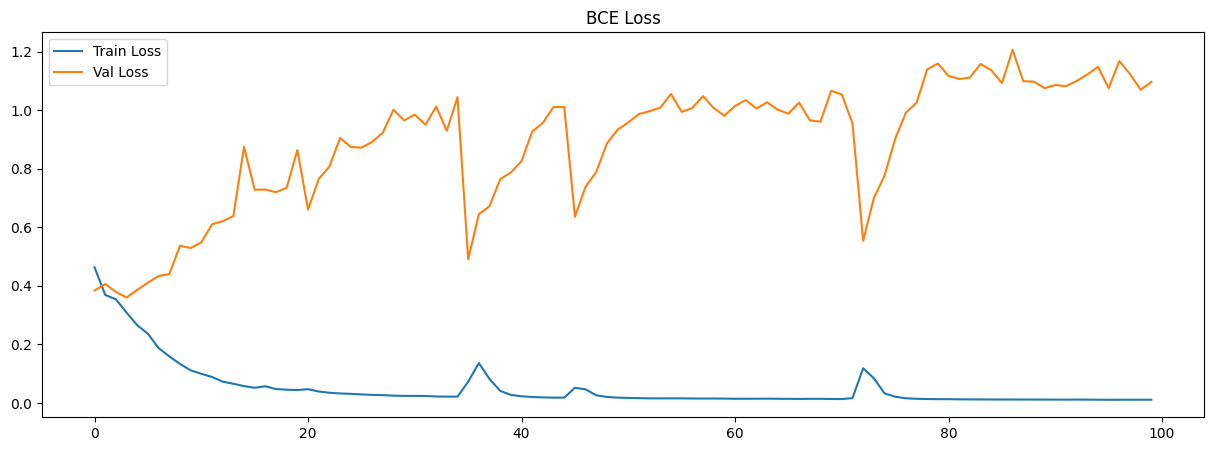

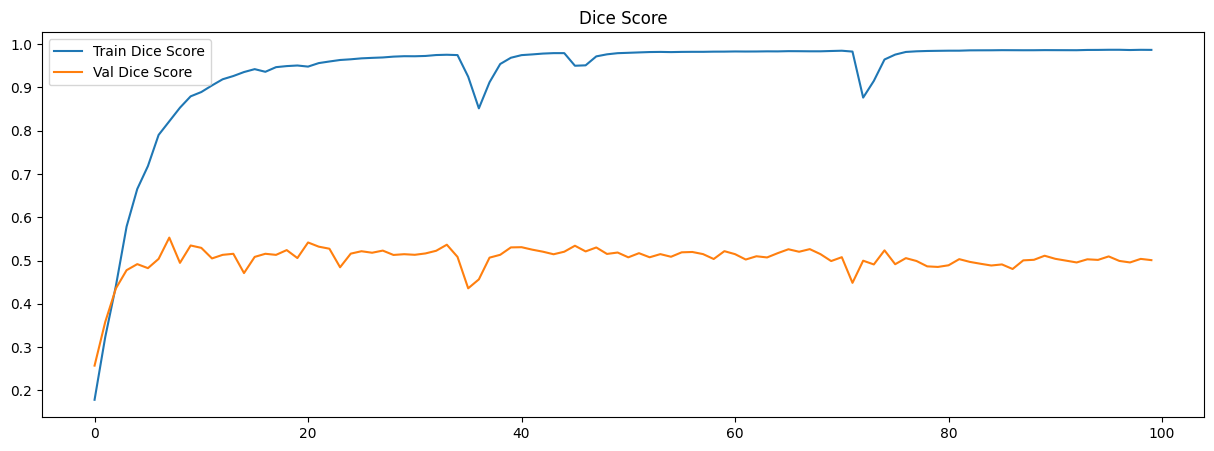

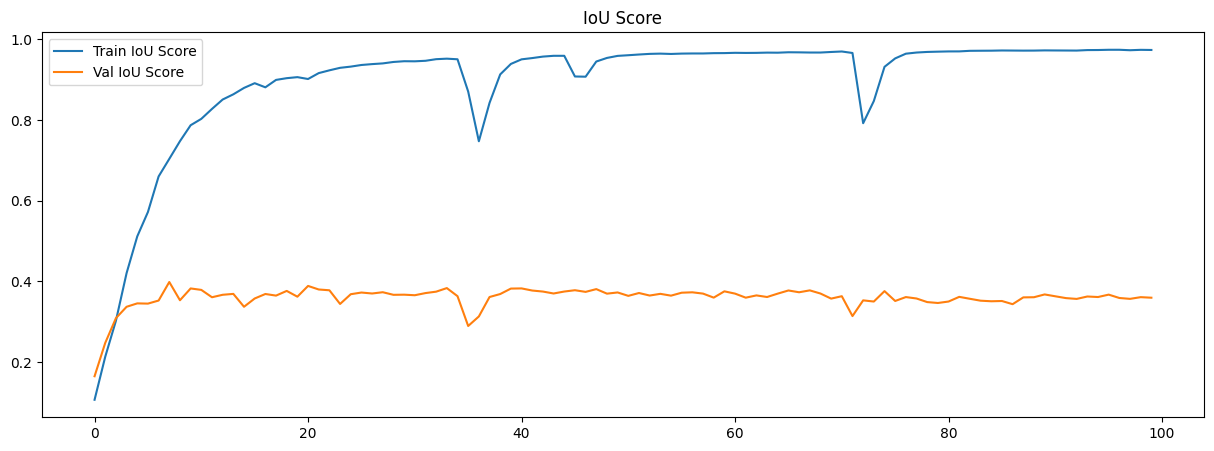

In [ ]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import f1_score, jaccard_score
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet34(n_classes=1).to(device)
criterion = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 100  # Default = 25
save_interval = 10
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []
train_iou_scores = []
val_iou_scores = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_dice_score = 0.0
    train_iou_score = 0.0

    # Add tqdm to train_loader
    for images, annotations, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        images, annotations = images.to(device), annotations.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        if outputs.shape != annotations.shape:
            annotations = F.interpolate(annotations, size=outputs.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(outputs, annotations)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Convert predictions to binary
        preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
        true_masks = annotations.cpu().numpy().astype(bool)

        train_dice_score += f1_score(true_masks.flatten(), preds.flatten(), average='binary')
        train_iou_score += jaccard_score(true_masks.flatten(), preds.flatten(), average='binary')

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_dice_scores.append(train_dice_score / len(train_loader))
    train_iou_scores.append(train_iou_score / len(train_loader))

    model.eval()
    val_loss = 0.0
    val_dice_score = 0.0
    val_iou_score = 0.0

    # Add tqdm to val_loader
    with torch.no_grad():
        for images, annotations, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
            images, annotations = images.to(device), annotations.to(device)
            outputs = model(images)

            if outputs.shape != annotations.shape:
                annotations = F.interpolate(annotations, size=outputs.shape[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, annotations)
            val_loss += loss.item()

            # Convert predictions to binary
            preds = torch.sigmoid(outputs).detach().cpu().numpy() > 0.5
            true_masks = annotations.cpu().numpy().astype(bool)

            val_dice_score += f1_score(true_masks.flatten(), preds.flatten(), average='binary')
            val_iou_score += jaccard_score(true_masks.flatten(), preds.flatten(), average='binary')

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_dice_scores.append(val_dice_score / len(val_loader))
    val_iou_scores.append(val_iou_score / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Dice Score: {train_dice_score:.4f}, Val Dice Score: {val_dice_score:.4f}, Train IoU Score: {train_iou_score:.4f}, Val IoU Score: {val_iou_score:.4f}")

    if (epoch + 1) % save_interval == 0:
        model_path = f"defect_detect_trained_model_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

# Final model saving
final_model_path = "defect_detect_trained_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"Model saved to {final_model_path}")

# # Load the model
# loaded_model = UNetResNet34(n_classes=1).to(device)
# checkpoint = torch.load('defect_detect_trained_model_final.pth')  # Specify the checkpoint file
# loaded_model.load_state_dict(checkpoint)

# Plotting the metrics
plt.figure(figsize=(15, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('BCE Loss')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(train_dice_scores, label='Train Dice Score')
plt.plot(val_dice_scores, label='Val Dice Score')
plt.legend()
plt.title('Dice Score')
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(train_iou_scores, label='Train IoU Score')
plt.plot(val_iou_scores, label='Val IoU Score')
plt.legend()
plt.title('IoU Score')

plt.show()

Validate model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


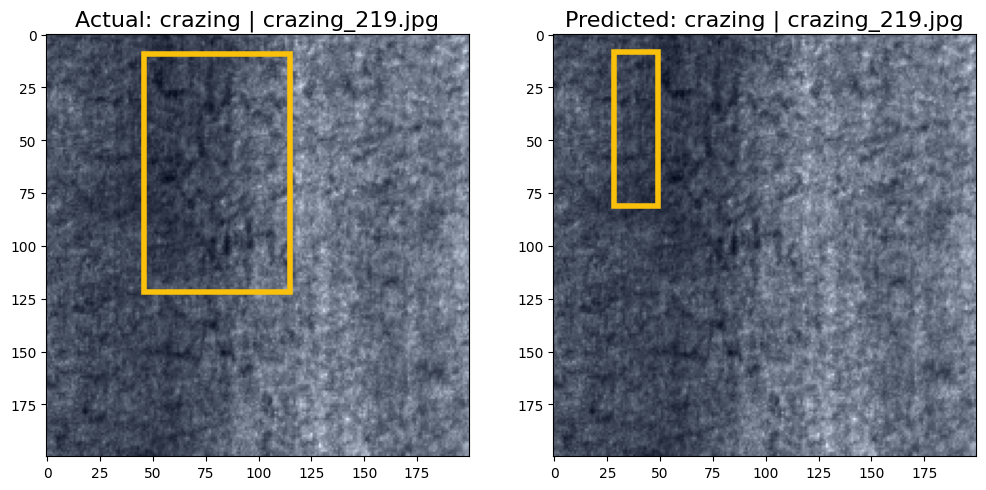

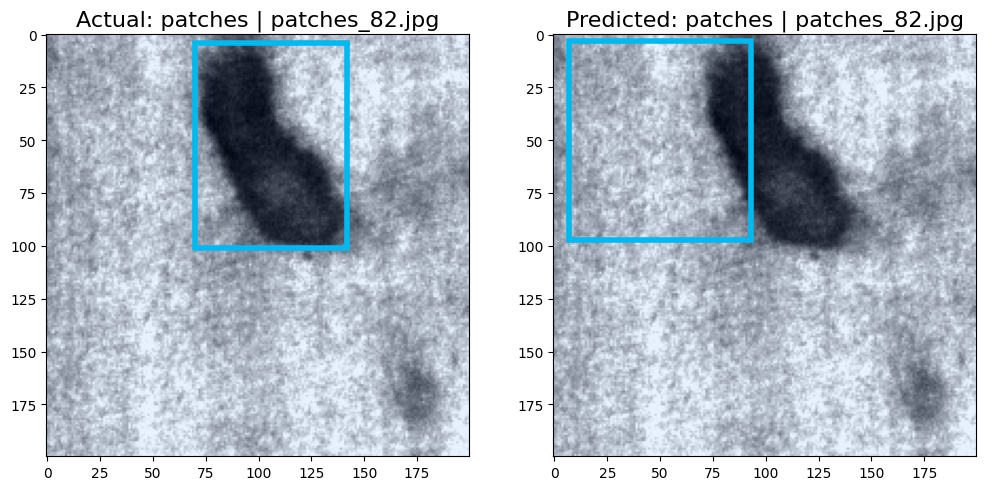

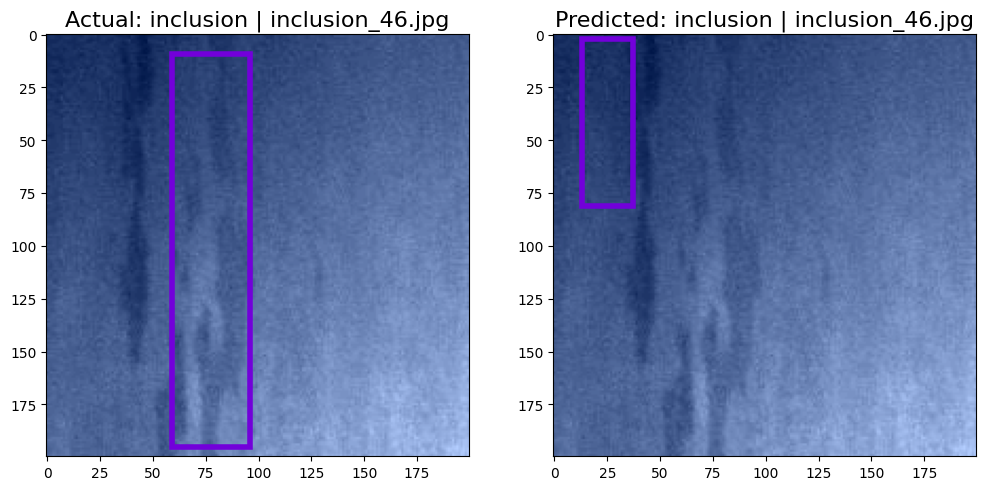

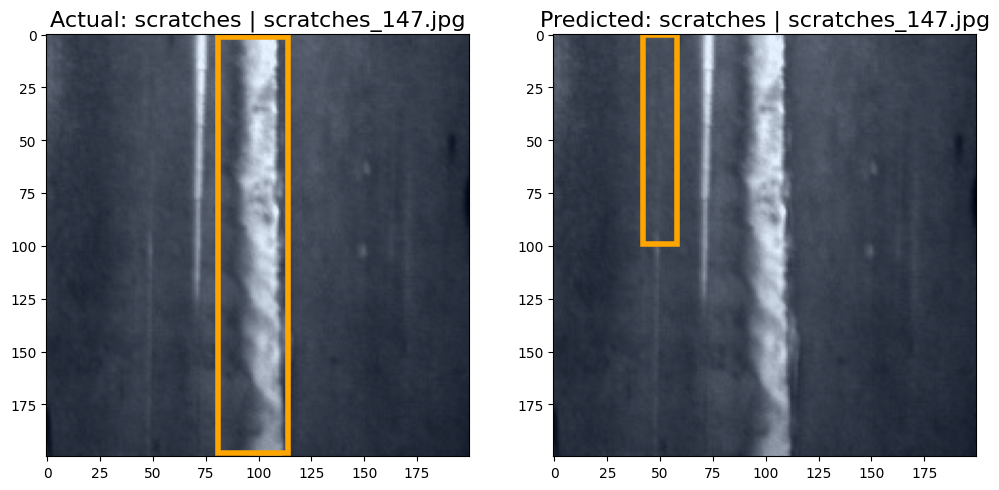

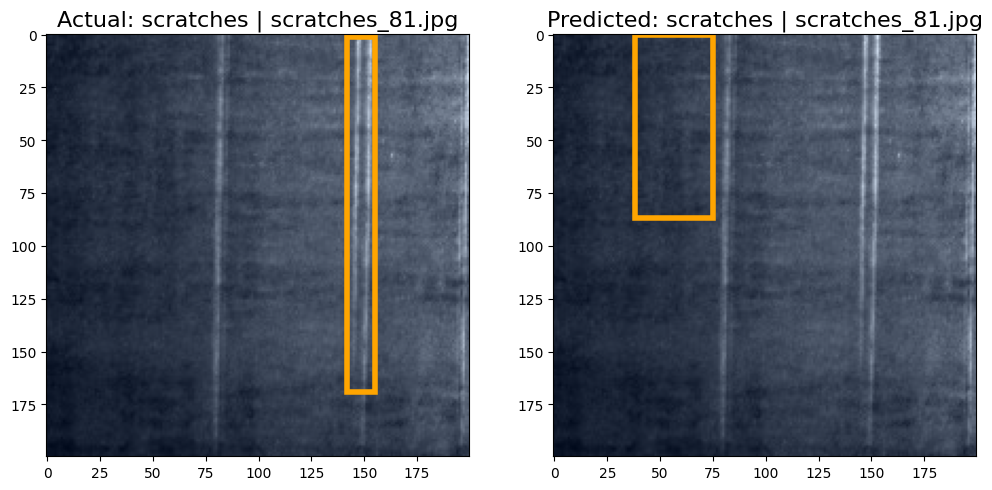

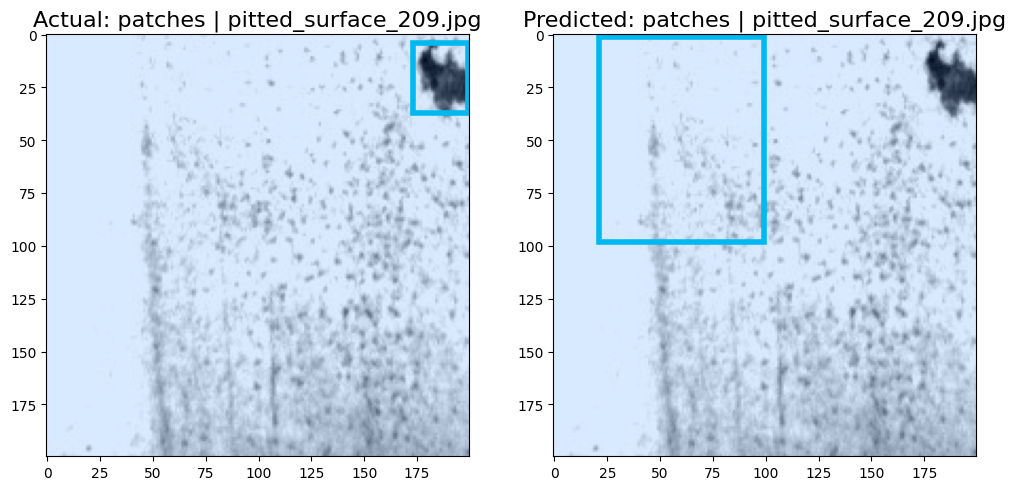

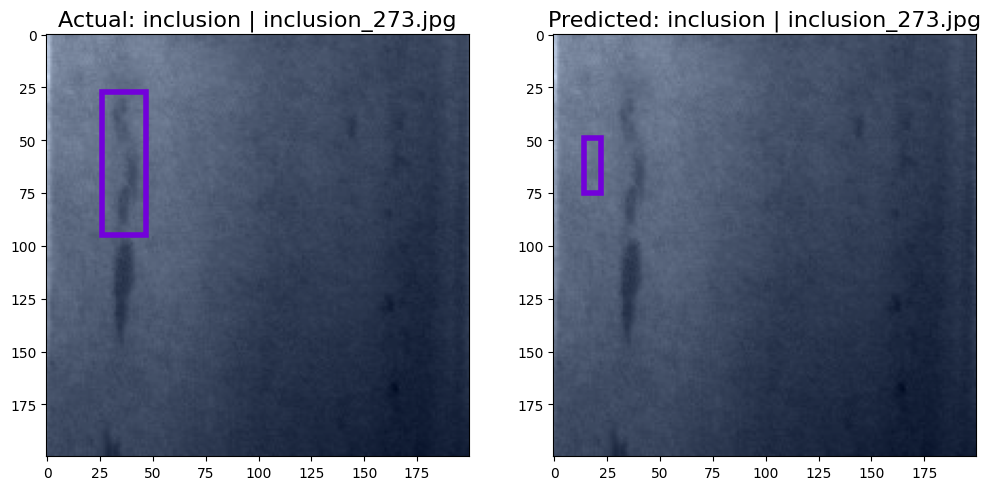

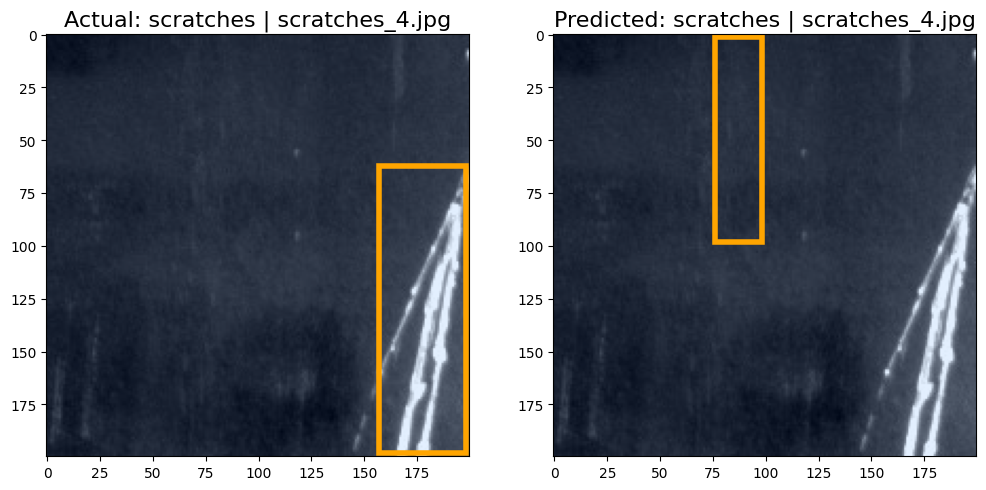

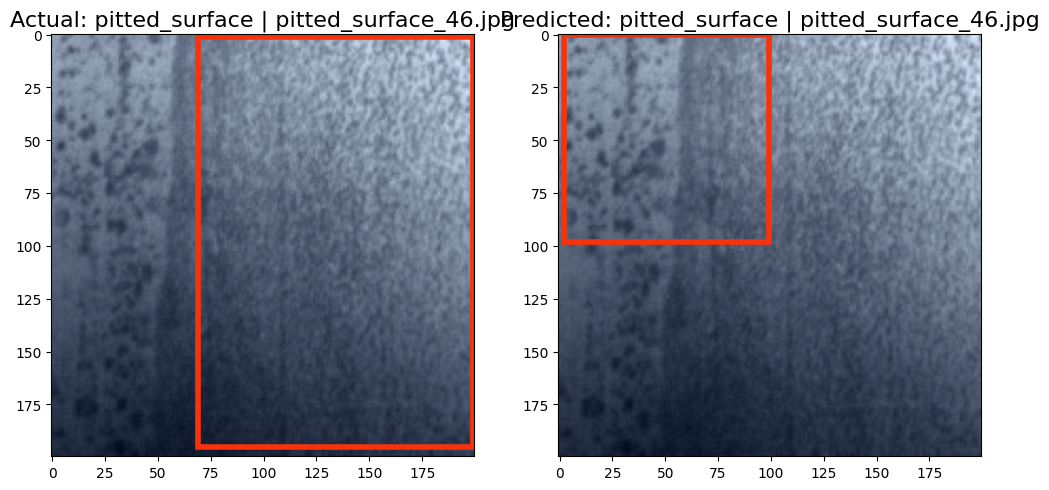

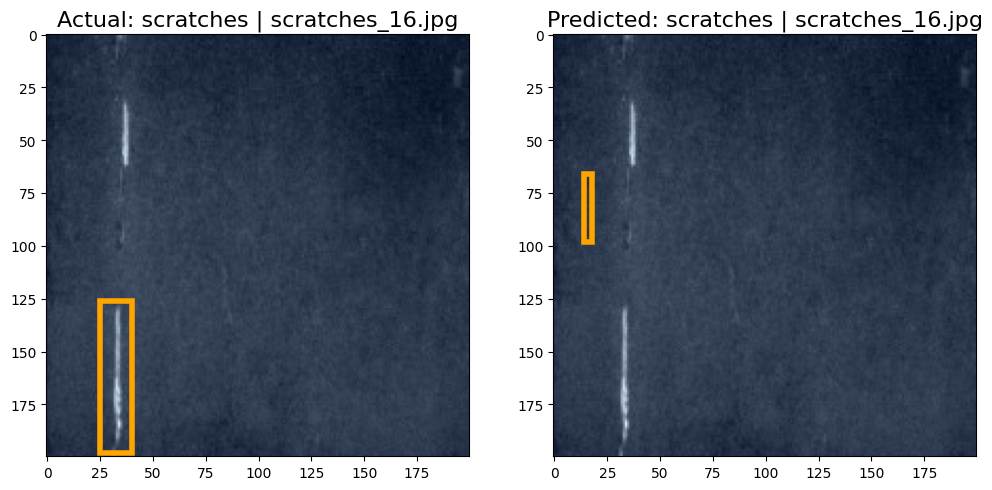

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Define the defects and their corresponding colors
defects = ["crazing", "patches", "inclusion", "pitted_surface", "rolled-in_scale", "scratches"]
palet = [(249, 192, 12), (0, 185, 241), (114, 0, 218), (249, 50, 12), (0, 255, 0), (255, 165, 0)]
color_map = {defects[i]: np.array(palet[i]) / 255.0 for i in range(len(defects))}

def mask_to_bbox(mask):
    """Convert a binary mask to a bounding box."""
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    if rows.any() and cols.any():
        y_min, y_max = np.where(rows)[0][[0, -1]]
        x_min, x_max = np.where(cols)[0][[0, -1]]
        return [x_min, y_min, x_max, y_max]
    else:
        return [0, 0, 0, 0]

def normalize_image(image):
    """Normalize image data to the range [0, 1]."""
    image_min = image.min()
    image_max = image.max()
    return (image - image_min) / (image_max - image_min)

def visualize_predictions(images, annotations, preds, classes, filenames):
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0).cpu().numpy()
        annotation = annotations[i].cpu().numpy().squeeze()
        pred = preds[i].cpu().numpy().squeeze()

        # Normalize image data
        image = normalize_image(image)

        # Convert masks to bounding boxes
        annotation_bbox = mask_to_bbox(annotation)
        pred_bbox = mask_to_bbox(pred)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))

        defect_class = classes[i]
        color = color_map.get(defect_class, 'red')

        ax[0].imshow(image)
        ax[0].set_title(f"Actual: {defect_class} | {filenames[i]}", fontsize=16)
        rect = plt.Rectangle((annotation_bbox[0], annotation_bbox[1]), annotation_bbox[2]-annotation_bbox[0], annotation_bbox[3]-annotation_bbox[1], fill=False, color=color, linewidth=4)
        ax[0].add_patch(rect)

        ax[1].imshow(image)
        ax[1].set_title(f"Predicted: {defect_class} | {filenames[i]}", fontsize=16)
        rect = plt.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2]-pred_bbox[0], pred_bbox[3]-pred_bbox[1], fill=False, color=color, linewidth=4)
        ax[1].add_patch(rect)

        plt.show()

# Load the model
loaded_model = UNetResNet34(n_classes=1).to(device)
checkpoint = torch.load('defect_detect_trained_model_final.pth')  # Specify the checkpoint file
loaded_model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    for images, annotations, filenames in val_loader:
        images, annotations = images.to(device), annotations.to(device)
        outputs = loaded_model(images)
        preds = torch.sigmoid(outputs).round()
        visualize_predictions(images, annotations, preds, val_classes, filenames)
        break
